# Alcohol Effects on Young Adults

This project uses Kaggle's [Alcohol Consumption and Average Grades survey](https://www.kaggle.com/uciml/student-alcohol-consumption) among Portugese high school students attending Gabriel Pereira and Mousinho da Silveira. This data was obtained in a survey of students in math and portguese language courses in attempt to find factors that might be predictive of student grades. I choose this dataset as I am interested in the field of pharmaceuticals and their affect on health, specifically commonplace ones such as alcohol.

For the purposes of this study, we will assume it is representative of the entire school population for those two high schools and is therefore representative of the effects alcohol has on the student bodies of these two high schools. Further, we will assume that all of the data in each variable is completely independent.

The dataset itself consists of two tables, one for math students and one for portugese language students. For these purposes we will focus on only one of the two files, math students. The math students file contains a school, sex, age, address, family size, parent's cohabitation status, mother's education, father's education, mother's job, father's job, reason for choosing this school, student's guardian, home to school travel time, weekly study time, number of past class failures, extra educational support, family education support,  extra paid classes within the course subject, extra-curricular activities, attended nursery school, wants to take higher education, Internet access at home, with a romantic relationship, quality of family relationships, free time after school, going out with friends, workday alcohol consumption, weekend alcohol consumption, current health status, number of school absences.

There are several challenges to this dataset, particularly that there are multiple types of data that we will be manipulating to answer our questions - continuous and binary. Some of the continuous data we will be using, such as alcohol consumption, is continuous but is subjective as it is a rating system rather than a concrete number, such as a grade. 

In [1]:
import pandas as pd
from scipy.stats import ttest_ind
from scipy.stats import chisquare
import matplotlib.pyplot as plt
import numpy as np

### Questions:
1. Does increased alcohol consumption either during the weekday or weekend increase absences from class?
2. Are people who have increased alcohol consumption either during the weekday or weekend less likely to have a romantic partner?
3. Does increased alcohol consumption either during the weekday or weekend decrease final grade?

In [2]:
student_data = pd.read_csv("student-mat.csv")

In [3]:
#Trimming data down from 33 columns to focus on key elements
student_data_trim = student_data.loc[:,["age","failures","romantic",
                                        "Dalc","Walc","absences","G3"]]

In [4]:
#Function to turn binary column (yes/no) into usable boolean
def convert_yesno(x):
    if x == "yes":
        return True
    elif x == "no":
        return False
    else:
        return x

In [5]:
#Convert one binary column in dataset to usable boolean
student_data_trim.romantic = student_data_trim.romantic.map(convert_yesno)

__#1 Does increased alcohol consumption either during the weekday or weekend increase absences from class?__

In [6]:
#Taking a look at the breakdown of Dalc (weekday alcohol consumption)
student_data_trim["Dalc"].value_counts()

1    276
2     75
3     26
5      9
4      9
Name: Dalc, dtype: int64

In [50]:
#Based on value counts, we will separate weekday drinking data into 1 and 2+ groups.
#Additionally removed of outliers after working data
dalc_one = student_data_trim.loc[(student_data_trim["Dalc"] == 1) & 
                                 (student_data_trim["absences"] <= 30), 
                                 "absences"]
dalc_one.head()

0     6
1     4
3     2
4     4
5    10
Name: absences, dtype: int64

In [8]:
dalc_greater = student_data_trim.loc[(student_data_trim["Dalc"] > 1) &
                                     (student_data_trim["absences"] <= 30),
                                     "absences"]

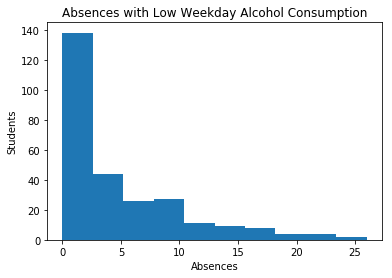

In [105]:
plt.hist(dalc_one);
plt.xlabel("Absences")
plt.ylabel("Students")
plt.title("Absences with Low Weekday Alcohol Consumption")
plt.show()

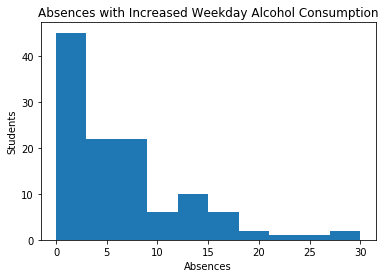

In [103]:
plt.hist(dalc_greater);
plt.xlabel("Absences")
plt.ylabel("Students")
plt.title("Absences with Increased Weekday Alcohol Consumption")
plt.show()

While we can see there is a difference between these graphs, they look more exponetial than normal. Before moving foward with a t-test to test significance, we must first prove normality either using QQ test or using Central Limit Theorem.

In [11]:
#Function to create QQ Test to test normality
def test_normal(dataframe, name):
    #Use case for dataframe
    if type(dataframe) == pd.core.series.Series:
        normal = np.random.normal(0,1,dataframe.count())
        plt.plot(sorted(normal), dataframe.sort_values());
    #Use case for list
    elif type(dataframe) == list:
        normal = np.random.normal(0,1,len(dataframe))
        plt.plot(sorted(normal), sorted(dataframe));
    plt.title("QQ Test for {}".format(name))
    plt.show()

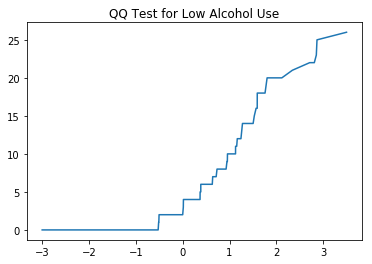

In [12]:
test_normal(dalc_one,"Low Alcohol Use")

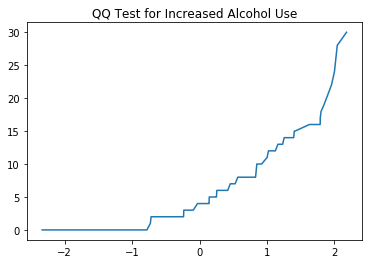

In [13]:
test_normal(dalc_greater, "Increased Alcohol Use")

Neither low nor increased alcohol use is normally distributed. We will use random samples of the population to prove that the means are normally distributed and that we can use the t-test confidently.  

In [14]:
#Function to get sample mean list sample_num items long
def mean_sample(dataframe, sample_num):
    mean_list=[]
    for x in range(sample_num):
        y = np.random.choice(dataframe, 100, replace=True)
        mean_list.append(y.mean())
    return mean_list

In [15]:
d1_mean_list = mean_sample(dalc_one, 300)
dplus_mean_list = mean_sample(dalc_greater, 300)

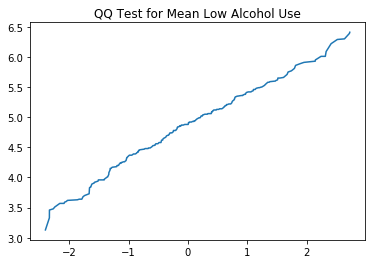

In [16]:
test_normal(d1_mean_list, "Mean Low Alcohol Use")

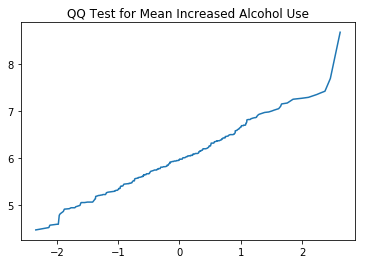

In [17]:
test_normal(dplus_mean_list, "Mean Increased Alcohol Use")

In [18]:
#Means are normally distributed, so we can confidently use T-test
print(ttest_ind(dalc_greater, dalc_one, equal_var=False))

Ttest_indResult(statistic=1.818676142398681, pvalue=0.07047648528000246)


P-value is more than 0.05, so at the 95% confidence level reject the hypothesis that increased alcohol consumption during the **weekday** increases school absences.

In [51]:
#Looking at Walc data (weekend alcohol consumption)
student_data_trim["Walc"].value_counts()

1    151
2     85
3     80
4     51
5     28
Name: Walc, dtype: int64

In [20]:
#Based on value counts, we will compare groups 1, 2+ 
#First let's start with making a function to create the dataframes

In [21]:
def absence_df(walc, equiv):
    if equiv == "=":
        return student_data_trim.loc[(student_data_trim["Walc"] == walc) &
                                     (student_data_trim["absences"] <=30), 
                                     "absences"]
    elif equiv == ">":
        return student_data_trim.loc[(student_data_trim["Walc"] >= walc) &
                                     (student_data_trim["absences"] <=30), 
                                     "absences"]
    elif equiv == "<":
        return student_data_trim.loc[(student_data_trim["Walc"] <= walc) &
                                     (student_data_trim["absences"] <=30), 
                                     "absences"]
    else:
        print("Wrong Input")

In [22]:
#Creating two lists to compare
walc_one = absence_df(1, "=")
walc_more = absence_df(2, ">")

In [23]:
print(walc_one.mean())
print(walc_more.mean())

3.918918918918919
5.8347107438016526


In [24]:
#On the surface, it does look like increasing drinks on the weekend, does increase absences

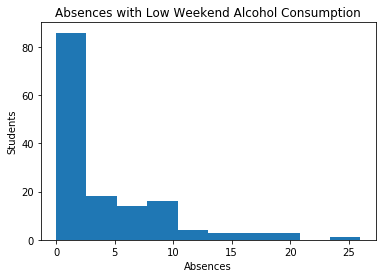

In [102]:
plt.hist(walc_one);
plt.xlabel("Absences")
plt.ylabel("Students")
plt.title("Absences with Low Weekend Alcohol Consumption")
plt.show()

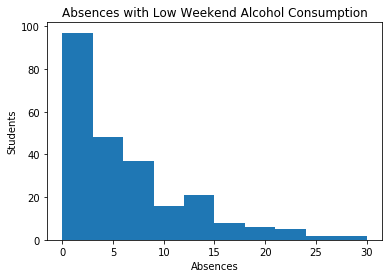

In [101]:
plt.hist(walc_more);
plt.xlabel("Absences")
plt.ylabel("Students")
plt.title("Absences with Low Weekend Alcohol Consumption")
plt.show()

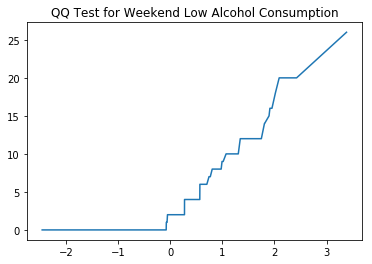

In [27]:
test_normal(walc_one, "Weekend Low Alcohol Consumption")

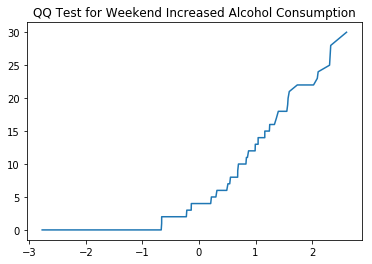

In [28]:
test_normal(walc_more, "Weekend Increased Alcohol Consumption")

Neither low nor increased alcohol use is normally distributed. We will use random samples of the population to prove that the means are normally distributed and that we can use the t-test confidently.  

In [29]:
w1_mean_sample = mean_sample(walc_one, 400)
wplus_mean_sample = mean_sample(walc_more, 300)

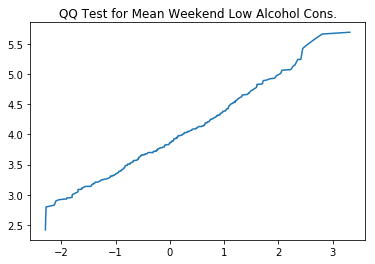

In [30]:
test_normal(w1_mean_sample, "Mean Weekend Low Alcohol Cons.")

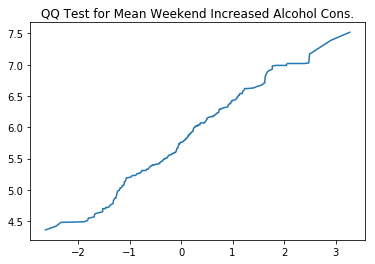

In [31]:
test_normal(wplus_mean_sample, "Mean Weekend Increased Alcohol Cons.")

In [53]:
#Function for comparing the two dataframes at a time
def absence_compare(df1, df2):
    
    pvalue = ttest_ind(df2, df1, equal_var=False)[1]
    if pvalue <= 0.05:
        print(ttest_ind(df2, df1, equal_var=False))
    else:
        print("Not significant at 95% confidence level.")
    
absence_compare(walc_one, walc_more)

Ttest_indResult(statistic=3.3324776971878465, pvalue=0.0009516648060095118)


With the p-value at 0.001, we reject the null hypothesis at a 98% confidence level. There is an increase in absences from school due to excessive drinking on **weekends**. Excessive drinking is defined as moderate to very high levels (2-5).

__#2. Are people who have increased alcohol consumption either during the weekday or weekend less likely to have a romantic partner?__

Taking a look at total alcohol consumption's affects on romantic relationships by combining Dalc(weekday alcohol consumption) and Walc (weekend consumption). Total alcohol consumption equivalent to 2 (Dalc = 1, Walc = 1) indicates a light drinker, while increased consumption falls in the category of total alcohol consumption 3 or more.

In [80]:
student_test_d = (student_data_trim["Dalc"]+student_data_trim["Walc"]).groupby(student_data_trim["romantic"]).value_counts()
print(student_test_d)


romantic    
False     2     100
          3      44
          4      35
          5      31
          6      28
          7      13
          8       6
          10      4
          9       2
True      2      50
          4      25
          3      22
          5      14
          6       7
          10      5
          7       4
          8       3
          9       2
dtype: int64


In [84]:
#Creating light drinkers Talc (total alcohol)
talc_light_romantic = student_data_trim.loc[((student_data_trim["Dalc"] == 1) & 
                                            (student_data_trim["Walc"] == 1)), 
                                            "romantic"]

In [85]:
talc_light_romantic.mean()

0.3333333333333333

In [86]:
#Creating heavy drinkers Talc (total alcohol)
talc_heavy_romantic = student_data_trim.loc[((student_data_trim["Dalc"] > 1) | 
                                            (student_data_trim["Walc"] > 1)), 
                                            "romantic"]

In [87]:
talc_heavy_romantic.mean()

0.3346938775510204

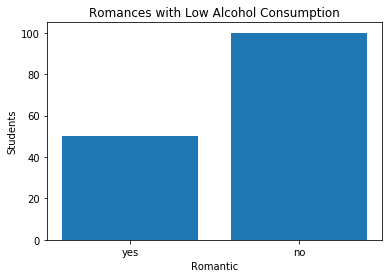

In [118]:
#Taking a look at the binary data
plt.bar([0,1],[talc_light_romantic.sum(),(~dalc_light_romantic).sum()]);
plt.xlabel("Romantic")
plt.xticks([0,1], ["yes","no"])
plt.ylabel("Students")
plt.title("Romances with Low Alcohol Consumption")
plt.show()

In [119]:
#Checking to make sure that graph makes sense for the data
print(len(talc_light_romantic))

150


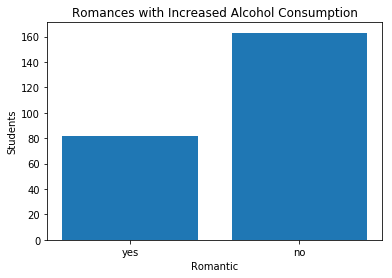

In [91]:
plt.bar([0,1],[talc_heavy_romantic.sum(),(~dalc_heavy_romantic).sum()]);
plt.xlabel("Romantic")
plt.xticks([0,1], ["yes","no"])
plt.ylabel("Students")
plt.title("Romances with Increased Alcohol Consumption")
plt.show()

In [92]:
print(len(talc_heavy_romantic))

245


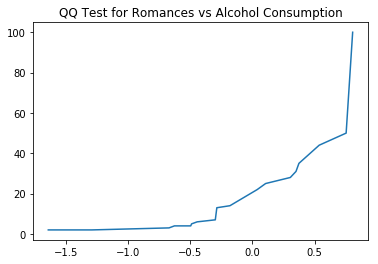

In [124]:
test_normal(student_test_d, "Romances vs Alcohol Consumption")

Previously we have supported the Central Limits Theroem that while the QQ test may not prove normality, the means of the data are normally distributed and therefore we can use this test. This is also cited in Fagerland's article "t-tests, non-parametric tests, and large studies--a paradox of statistical practice?" where he states that for studies with a large sample size, t-tests and their corresponding confidence intervals can and should be used even for heavily skewed data. Therefore, we will move forward with the t-test.

In [93]:
ttest_ind(talc_heavy_romantic,talc_light_romantic)

Ttest_indResult(statistic=0.027750652138720706, pvalue=0.9778751107227512)

The data doesn't support the hypothesis at a 95% confidence level that increased total alcohol consumption would decreased romantic relationships (p-value of 0.98). 

__#3. Does increased alcohol consumption either during the weekday or weekend decrease final grade?__

In [94]:
#Taking a look at average G3 (final grade), approximately half of the highest mark of 20.
print(student_data_trim["G3"].mean())
print(student_data_trim["G3"].max())

10.415189873417722
20


Data is continuous and similar to process done above for absences so here we will just make a function to study weekday alcohol consumption (Dalc) and weekend alcohol consumption (Walc).

In [114]:
def analyze_finalgrade(alc):
    student_grade_d1 = student_data_trim.loc[(student_data_trim[alc] == 1), "G3"]
    student_grade_d2 = student_data_trim.loc[(student_data_trim[alc] > 1), "G3"]
    print("Low alcohol consumption mean is {}".format(student_grade_d1.mean()))
    print("Increased alcohol consumption mean is {}".format(student_grade_d2.mean()))
    plt.hist(student_grade_d1)
    plt.xlabel("Final Grade")
    plt.ylabel("Students")
    plt.title("Final Grade with Low Weekday Alcohol Consumption")
    plt.show()
    plt.hist(student_grade_d2)
    plt.xlabel("Final Grade")
    plt.ylabel("Students")
    plt.title("Final Grade with Increased Weekday Alcohol Consumption")
    plt.show()
    test_normal(student_grade_d1, "Low Alcohol vs Final Grade")
    test_normal(student_grade_d2, "Increased Alcohol vs Final Grade")
    print(ttest_ind(student_grade_d1, student_grade_d2))

Low alcohol consumption mean is 10.731884057971014
Increased alcohol consumption mean is 9.680672268907562


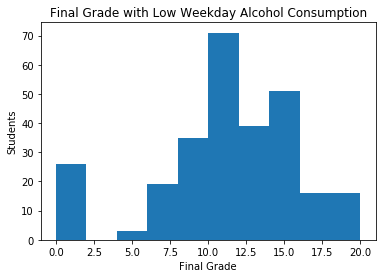

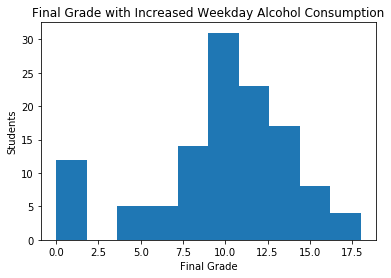

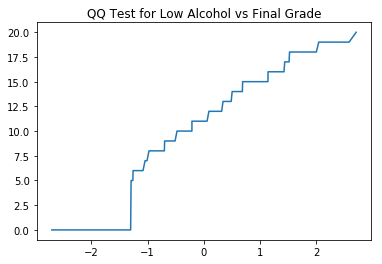

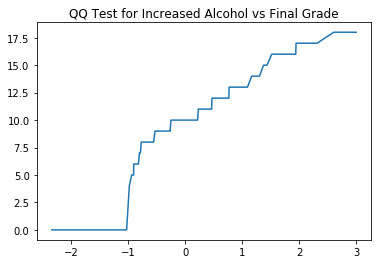

Ttest_indResult(statistic=2.1013178794606784, pvalue=0.03624930129858336)


In [115]:
analyze_finalgrade("Dalc")

While histogram looks approximately normal, QQ test shows that it is not. Previously we have support the Central Limits Theroem that while the QQ test may not prove normality, the means of the data are normally distributed and therefore we can use this test. Therefore, we will move forward with the t-test.

With a p-value of less than 0.05, we can reject the null hypothesis at a 95% confidence level. We can see that there is a correlation with increased drinking during the **weekday** and decreased final grades.

Low alcohol consumption mean is 10.735099337748345
Increased alcohol consumption mean is 10.217213114754099


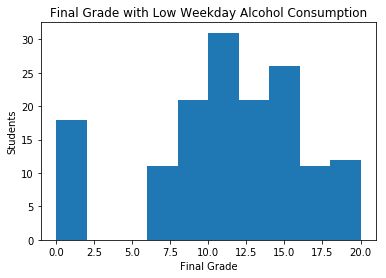

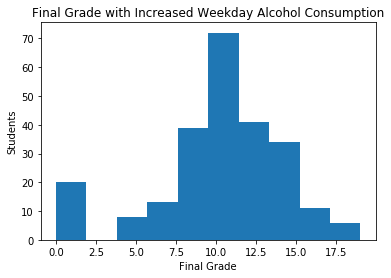

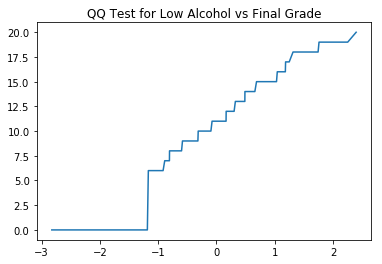

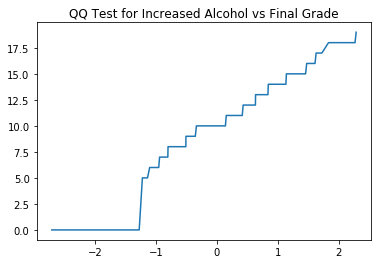

Ttest_indResult(statistic=1.0920008966512462, pvalue=0.2755016854250634)


In [116]:
analyze_finalgrade("Walc")

At a 95% We can see no correlation between increased drinking on the **weekends** and decreased final grades. 

### Final Summary
Based on this dataset, we have come to the following conclusions:
1. Increased alcohol consumption on the weekends correlates to an increase in total school absences, while weekday alcohol consumption has no correlation.
2. Total alcohol consumption has no correlation to a decrease in romantic relationships.
3. Increased alcohol consumption on the weekdays correlates to an decrease in final grade, while weekend alcohol consumption has no correlation.

Now that we know this information, I would suggest that we take a more indepth look to quantify how many drinks people are taking per week and use that information to predict their potential to get into higher education schools.